In [1]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import tensorflow as tf
from tensorflow import keras
import numpy as np

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform

In [2]:
!nvidia-smi


Sat Nov  6 15:58:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    37W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

In [ ]:
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D

## Định nghĩa 1 Residual Block
class ResidualBlock(keras.layers.Layer):

    def __init__(self, n_filters=64, n_filters_1=256, kernel_regularizer=None, down_sampling=False):
        ## Gọi hàm khởi tạo của keras.layers.Layer và lưu lại các thông số
        super(ResidualBlock, self).__init__()
        self.n_filters = n_filters
        self.n_filters_1 = n_filters_1
        self.down_sampling = down_sampling
        self.kernel_regularizer = kernel_regularizer
    
    ## override hàm này để có thể lưu file
    def get_config(self):
        ## lấy config của lớp cha
        config = super(ResidualBlock, self).get_config()
        ## thêm config của lớp này
        config.update({
            'n_filters': self.n_filters,
            "down_sampling": self.down_sampling,
        })
        return config
    
    def build(self, input_shape):
        
        ## Xác định xem input_shape có bằng output_shape không
        self.projection_shortcut = (int(input_shape[-1]) != self.n_filters_1) or self.down_sampling
        ## Nếu cần down sampling thì convolutional layer đầu tiên dùng strides=[2,2]
        first_strides = [1,1]
        if self.down_sampling:
            first_strides = [2,2]
        
        ##Khai báo các layer nhánh chính
        self.main_conv1 = Convolution2D(filters=self.n_filters,
                                         kernel_size=[1,1],
                                         strides=first_strides,
                                         padding='same',
                                         kernel_regularizer=self.kernel_regularizer,
                                         activation=None)
        self.main_batch1 = BatchNormalization()
        self.main_relu1 = ReLU()

        self.main_conv2 = Convolution2D(filters=self.n_filters,
                                              kernel_size=[3,3],
                                              strides=[1,1],
                                              padding='same',
                                              kernel_regularizer=self.kernel_regularizer,
                                              activation=None)
        self.main_batch2 = BatchNormalization()
        self.main_relu2 = ReLU()

        self.main_conv3 = Convolution2D(filters=self.n_filters_1,
                                              kernel_size=[1,1],
                                              strides=[1,1],
                                              padding='same',
                                              kernel_regularizer=self.kernel_regularizer,
                                              activation=None)
        self.main_batch3 = BatchNormalization()
        self.main_relu3 = ReLU()


        
        ## Khai báo các layer nhánh shortcut
        if self.projection_shortcut:
            self.shortcut_conv = Convolution2D(filters=self.n_filters_1,              ### N_FILETERS bằng N_FILTERS của output
                                                        kernel_size=[1,1],          ### KERNEL_SIZE = [1,1]
                                                        strides=first_strides,      ### STRIDES: giống STRIDES của conv đầu
                                                        padding='same',
                                                        kernel_regularizer=self.kernel_regularizer,
                                                        activation=None)
            self.shortcut_batch = BatchNormalization()

        self.main_relu2 = ReLU()

    def call(self, inputs):
        
        ## Thiết lập các input cho các layer đã khai báo
        main_conv1 = self.main_conv1(inputs)
        main_batch1 = self.main_batch1(main_conv1)
        main_relu1 = self.main_relu1(main_batch1)
        
        main_conv2 = self.main_conv2(main_relu1)
        main_batch2 = self.main_batch2(main_conv2)
        main_relu2 = self.main_relu2(main_batch2)

        main_conv3 = self.main_conv3(main_relu2)
        main_batch3 = self.main_batch3(main_conv3) 

        if self.projection_shortcut:
            shortcut_conv = self.shortcut_conv(inputs)
            shortcut_batch = self.shortcut_batch(shortcut_conv)
            
            ## Nếu input_shape != output_shape thì shortcut là convolutional layer
            shortcut = shortcut_batch
        else:
            ## Nếu input_shape == output_shape thì shortcut là inputs
            shortcut = inputs

        main_add = main_batch3 + shortcut

        main_relu3 = self.main_relu3(main_add)
        return main_relu3

In [ ]:
from keras.regularizers import l2
l2_regularizer_rate = 0.0001

## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = keras.layers.Input(shape=(28,28,1))

### Block 1
conv1 = Convolution2D(filters=64,
                      kernel_size=[7,7],
                      strides=[2,2],
                      padding='same',
                      kernel_regularizer=l2(l2_regularizer_rate),
                      activation=None)(inputs)

batch1 = BatchNormalization()(conv1)        ## lớp tf.keras.layers.BatchNormalization()

relu1 = ReLU()(batch1)

maxpool1 = MaxPool2D(pool_size=[3,3],
                     strides=[2,2])(relu1)

### Block 2

res2_1 = ResidualBlock(n_filters=64, n_filters_1=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(maxpool1)
res2_2 = ResidualBlock(n_filters=64, n_filters_1=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_1)
res2_3 = ResidualBlock(n_filters=64, n_filters_1=256,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_2)

### Block 3

res3_1 = ResidualBlock(n_filters=128, n_filters_1=512,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_3)
res3_2 = ResidualBlock(n_filters=128, n_filters_1=512,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_1)
res3_3 = ResidualBlock(n_filters=128, n_filters_1=512,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_2)
res3_4 = ResidualBlock(n_filters=128, n_filters_1=512,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_3)

### Block 4

res4_1 = ResidualBlock(n_filters=256,n_filters_1=1024,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_4)
res4_2 = ResidualBlock(n_filters=256, n_filters_1=1024,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_1)
res4_3 = ResidualBlock(n_filters=256, n_filters_1=1024,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_2)
res4_4 = ResidualBlock(n_filters=256, n_filters_1=1024,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_3)
res4_5 = ResidualBlock(n_filters=256, n_filters_1=1024,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_4)
res4_6 = ResidualBlock(n_filters=256, n_filters_1=1024,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_5)

### Block 5

res5_1 = ResidualBlock(n_filters=512, n_filters_1=2048,
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_6)
res5_2 = ResidualBlock(n_filters=512, n_filters_1=2048,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res5_1)
res5_3 = ResidualBlock(n_filters=512, n_filters_1=2048,
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res5_2)


### Block Output

avage_pool = GlobalAveragePooling2D()(res5_3)

softmax = Dense(units=10, activation='softmax')(avage_pool)

## Compile model
model = keras.models.Model(inputs=inputs, outputs=softmax)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),    ##tự khai báo Optimizer với learning rate 10^-4
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
    

## In toàn bộ cấu trúc của model
print("Cấu trúc của model: ")
model.summary()

Cấu trúc của model: 
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 64)          0         
_________________________________________________________________
residual_block (ResidualBloc (None, 6, 6, 256)         76928     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 6, 6

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


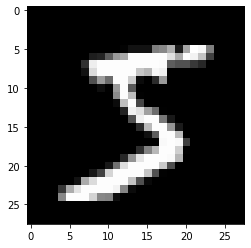

In [ ]:
# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào trong các số từ 1 đến 10

## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

## in thử ảnh một ảnh
print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=5e-5), loss=tf.keras.losses.sparse_categorical_crossentropy ,metrics=["accuracy"])

In [ ]:
history=model.fit(x=X_train, y=y_train,
                  epochs=20,
                  verbose=1,
                  validation_data=(X_valid,y_valid))

Epoch 1/20
1688/1688 [==============================] - 210s 102ms/step - loss: 4.6660 - accuracy: 0.1690 - val_loss: 4.2157 - val_accuracy: 0.2728
Epoch 2/20
1688/1688 [==============================] - 172s 102ms/step - loss: 3.6928 - accuracy: 0.3885 - val_loss: 3.1922 - val_accuracy: 0.5267
Epoch 3/20
1688/1688 [==============================] - 172s 102ms/step - loss: 2.9938 - accuracy: 0.6033 - val_loss: 2.7089 - val_accuracy: 0.6972
Epoch 4/20
1688/1688 [==============================] - 173s 103ms/step - loss: 2.6067 - accuracy: 0.7385 - val_loss: 2.4550 - val_accuracy: 0.7828
Epoch 5/20
1688/1688 [==============================] - 173s 102ms/step - loss: 2.4159 - accuracy: 0.8027 - val_loss: 2.2879 - val_accuracy: 0.8442
Epoch 6/20
1688/1688 [==============================] - 173s 103ms/step - loss: 2.3000 - accuracy: 0.8418 - val_loss: 2.2047 - val_accuracy: 0.8772
Epoch 7/20
1688/1688 [==============================] - 173s 103ms/step - loss: 2.2274 - accuracy: 0.8676 - val_

In [ ]:
evaluation=model.evaluate(X_test, y_test)
print("Model có độ chính xác là {} và loss là {}".format(evaluation[1], evaluation[0]))

313/313 [==============================] - 9s 29ms/step - loss: 1.9438 - accuracy: 0.9568
Model có độ chính xác là 0.9567999839782715 và loss là 1.9438409805297852
